In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
# Change working directory to be current folder
import os
os.chdir('/content/gdrive/My Drive/Umitron')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import cv2
import os
from glob import glob
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Check GPU coinfiguration in Colab
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
tf.config.list_physical_devices('CPU')

: 

# Explore the dataset


In [22]:
# only '.avi' videos are used

def load_all_file_names(input_path):

    names, labels = [], []
    random.seed(30)
   
    file_names = glob(input_path+'/*.mp4')
    lo_cnt, mi_cnt, hi_cnt = 0, 0, 0  
    for file_name in file_names:    
        if file_name.split('\\')[1].split('.')[0][-1] =='0':
            lo_cnt +=1
            labels.append(0)
            names.append(file_name)
        elif file_name.split('\\')[1].split('.')[0][-1] =='1':
            labels.append(1)
            names.append(file_name)
        elif file_name.split('\\')[1].split('.')[0][-1] =='2':
            labels.append(2)
            names.append(file_name)
                              
    c = list(zip(names,labels))
    shuffle(c)
    names, labels = zip(*c)
    return names, labels


In [24]:
input_path = "train"
#input_path = "../opt_flow/train"
names, labels = load_all_file_names(input_path)
train, labels = list(names), list(labels)

print(train, labels)

['train\\85551_2.mp4', 'train\\85578_1.mp4', 'train\\85555_2.mp4', 'train\\85393_1.mp4', 'train\\85582_1.mp4', 'train\\85323_0.mp4', 'train\\85602_2.mp4', 'train\\85577_0.mp4', 'train\\85604_1.mp4'] [2, 1, 2, 1, 1, 0, 2, 0, 1]


### Action recognition using C3D model

A modified C3D model is used in the workshop to reduce model training time for demonstration purpose.

- Reference: D. Tran, L. Bourdev, R. Fergus, L. Torresani, and M. Paluri, “Learning Spatiotemporal Features with 3D Convolutional Networks“, ICCV 2015, https://arxiv.org/abs/1412.0767

In [25]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def get_data(self, filename, label):
        cap = cv2.VideoCapture(filename)
        nframe = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('tot num of frames in the video :', nframe)
        
        frame_stack = np.array([])
        labels = []
        for n in range(0, nframe, self.depth):

            if  (nframe - n) < self.depth:
                break

            framearray = []
            for i in range(self.depth):

                ret, frame = cap.read()
                
                if ret:
                    frame = cv2.resize(frame, (self.height, self.width))
                    framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
                else:
                    print("Error reading frames")
                    break
            
            framearray = np.expand_dims(np.array(framearray), axis=0)
            frame_stack = np.vstack([frame_stack, framearray]) if frame_stack.size else framearray
            labels.append(label) 
        
        #print('len(labels) :', len(labels))
            
        cap.release()

        return frame_stack, labels

    
def loaddata(video_list, vid3d):
    X = np.array([])
    labels_list = []
    for idx, value in enumerate(video_list):
        # Display the progress
        if (idx % 100) == 0:
            print("process data %d/%d" % (idx, len(video_list)))
        filename = value
        label = int(value.split('.')[0][-1])
        print('filename :', filename, 'label :', label)
        frame_stack, labels = vid3d.get_data(filename, label)
        X = np.vstack([X, frame_stack]) if X.size else frame_stack
        labels_list.extend(labels)

    return X, labels_list

In [26]:
# Define parameter setting
class Args:
    batch = 128
    epoch = 5
    nclass = 3 # 11 action categories
    depth = 10
    rows = 32
    cols = 32
    skip = True # Skip: randomly extract frames; otherwise, extract first few frames

param_setting = Args()
img_rows = param_setting.rows
img_cols = param_setting.cols
frames = param_setting.depth
channel = 1
vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = param_setting.nclass


In [27]:
# Prepare training data
x, y = loaddata(train, vid3d)
x = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
#c = list(zip(x, y))
#shuffle(c)
#x, y = zip(*c)
#y = np.array(y)

x_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

y_train, y_test = np.array(y_train), np.array(y_test)
y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, nb_classes)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 
print(x_train.shape, X_test.shape, y_train.shape, y_test.shape)


process data 0/9
filename : train\85551_2.mp4 label : 2
tot num of frames in the video : 3594
filename : train\85578_1.mp4 label : 1
tot num of frames in the video : 1798
filename : train\85555_2.mp4 label : 2
tot num of frames in the video : 3594
filename : train\85393_1.mp4 label : 1
tot num of frames in the video : 3600
filename : train\85582_1.mp4 label : 1
tot num of frames in the video : 1795
filename : train\85323_0.mp4 label : 0
tot num of frames in the video : 1791
filename : train\85602_2.mp4 label : 2
tot num of frames in the video : 3597
filename : train\85577_0.mp4 label : 0
tot num of frames in the video : 1791
filename : train\85604_1.mp4 label : 1
tot num of frames in the video : 3597
Class values in the dataset are ...  [0. 1.]
(2009, 32, 32, 10, 1) (503, 32, 32, 10, 1) (2009, 3) (503, 3)


In [28]:
# np.savez("c3d_train.npz", X=x_train, Y=y_train)
# np.savez("c3d_test.npz",  X=x_test,  Y=y_test)
#with np.load("c3d_train.npz") as npzfile:
#    x_train = npzfile["X"]
#    y_train = npzfile["Y"]
    
#with np.load("c3d_test.npz") as npzfile:
#    X_test = npzfile["X"]
#    y_test = npzfile["Y"]
    
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 0)
    
print("Training data", X_train.shape, y_train.shape)
print("Validation data", X_val.shape, y_val.shape)
print("Test data", x_test.shape, y_test.shape)

Training data (1607, 32, 32, 10, 1) (1607, 3)
Validation data (402, 32, 32, 10, 1) (402, 3)
Test data (503, 32, 32, 10, 1) (503, 3)


In [29]:
# Define deep learning model
# This is simplified C3D model
c3d_model = Sequential()
c3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(X_train.shape[1:]), padding='same'))
c3d_model.add(Activation('relu'))
c3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
c3d_model.add(Activation('relu'))
c3d_model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
c3d_model.add(Dropout(0.2))

c3d_model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
c3d_model.add(Activation('relu'))
c3d_model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
c3d_model.add(Activation('relu'))
c3d_model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
c3d_model.add(Dropout(0.2))

c3d_model.add(Flatten(name='flatten_feature'))
c3d_model.add(Dense(512, activation='relu'))
c3d_model.add(Dropout(0.2))
c3d_model.add(Dense(nb_classes, activation='softmax'))

c3d_model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
#c3d_model.summary()

In [30]:
# You can uncomment if you want to re-build the model; otherwise, load them from the data files

history = c3d_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=1, shuffle=True)

#c3d_model.save_weights("c3d_opt_flow_RWF_2000.h5")

Epoch 1/20
13/13 [==============================] - 77s 6s/step - loss: 22.8473 - accuracy: 0.4431 - val_loss: 1.0353 - val_accuracy: 0.4478
Epoch 2/20
13/13 [==============================] - 78s 6s/step - loss: 0.9740 - accuracy: 0.4586 - val_loss: 0.8344 - val_accuracy: 0.4328
Epoch 3/20
13/13 [==============================] - 79s 6s/step - loss: 0.6613 - accuracy: 0.6416 - val_loss: 0.4696 - val_accuracy: 0.7985
Epoch 4/20
13/13 [==============================] - 78s 6s/step - loss: 0.3860 - accuracy: 0.8189 - val_loss: 0.2457 - val_accuracy: 0.8284
Epoch 5/20
13/13 [==============================] - 77s 6s/step - loss: 0.1772 - accuracy: 0.9091 - val_loss: 0.1598 - val_accuracy: 0.9055
Epoch 6/20
13/13 [==============================] - 79s 6s/step - loss: 0.1419 - accuracy: 0.9390 - val_loss: 0.1220 - val_accuracy: 0.9652
Epoch 7/20
13/13 [==============================] - 82s 6s/step - loss: 0.0841 - accuracy: 0.9708 - val_loss: 0.0560 - val_accuracy: 0.9801
Epoch 8/20
13/13 [=

In [31]:
# Load the pre-trained model
# c3d_model.load_weights("c3d_RWF_2000.h5")

# Evaluate the deep learning model
y_pred = c3d_model.predict(x_test, verbose=0)
print("Confusion matrix")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Accuracy Score :', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Confusion matrix
[[ 73   0   0]
 [  0 212   1]
 [  2   0 215]]
Accuracy Score : 0.9940357852882704


In [32]:
np.argmax(y_pred, axis=1)[0:10]

array([0, 2, 0, 1, 1, 0, 0, 0, 2, 2], dtype=int64)

In [33]:
np.argmax(y_test, axis=1)[0:10]

array([0, 2, 0, 1, 1, 0, 0, 0, 2, 2], dtype=int64)

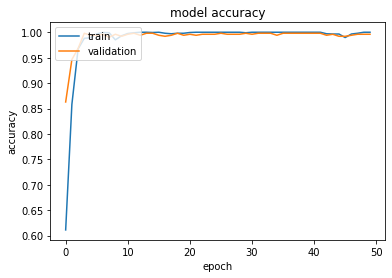

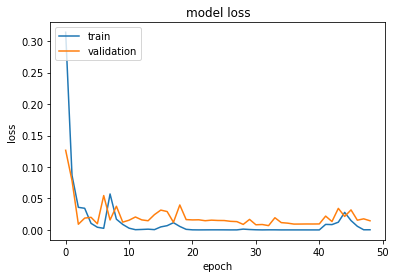

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('c3d_rgb_accuracy.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('c3d_rgb_loss.eps', format='eps', dpi=1000)
plt.show()

In [ ]:
import pandas as pd
df_history = pd.DataFrame(history.history, columns=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
df_history.to_csv('results/c3d_2000.csv')

$\color{black}{\text{Use fully connected layer response from the C3D model}}$

Tasks
- Extract the fully connected layer response `flatten_feature` from the C3D model `c3d_model` as features from the training data `x_train`
- Labels are provided in `ucf_train` and `ucf_test`
- Build a classification model, such as SVM
- Perform classification on `x_test`, display the confusion matrix


In [ ]:
# Load the pre-trained model
#c3d_model.load_weights("model_RWF_2000_c3d.h5")

# Evaluate the deep learning model
extract_flatten_feature = Model(inputs=c3d_model.input, outputs=c3d_model.get_layer('flatten_feature').output)
x_train_features = extract_flatten_feature.predict(x_train, verbose=0)
y_train_labels = np.array(labels[:train_count])
x_test_features = extract_flatten_feature.predict(x_test, verbose=0)
y_test_labels = np.array(labels[train_count:])
x_train_features.shape, y_train_labels.shape, x_test_features.shape, y_test_labels.shape

# from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train_features, y_train_labels)
y_pred = svm_clf.predict(x_test_features)
print('Confusion Matrix :')
print(confusion_matrix(y_pred, y_test_labels))
print('Accuracy Score :', accuracy_score(y_pred, y_test_labels))

In [ ]:
label = 1
labels = []

In [ ]:
labels.append(label)
print(labels)